In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

In [3]:
df_train = pd.read_csv("train.csv")
df_test  = pd.read_csv("test.csv")

In [4]:
print(df_train.shape, df_test.shape)
df_train.head()

(103904, 25) (25976, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [5]:
display(df_train.describe(include='all').T.head(15))
print("\nMissing values:\n", df_train.isna().sum().sort_values(ascending=False).head(12))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,103904.0,NaN,NaN,NaN,51951.5,29994.645522,0.0,25975.75,51951.5,77927.25,103903.0
id,103904.0,NaN,NaN,NaN,64924.210502,37463.812252,1.0,32533.75,64856.5,97368.25,129880.0
Gender,103904,2,Female,52727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer Type,103904,2,Loyal Customer,84923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,103904.0,NaN,NaN,NaN,39.379706,15.114964,7.0,27.0,40.0,51.0,85.0
Type of Travel,103904,2,Business travel,71655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class,103904,3,Business,49665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flight Distance,103904.0,NaN,NaN,NaN,1189.448375,997.147281,31.0,414.0,843.0,1743.0,4983.0
Inflight wifi service,103904.0,NaN,NaN,NaN,2.729683,1.327829,0.0,2.0,3.0,4.0,5.0
Departure/Arrival time convenient,103904.0,NaN,NaN,NaN,3.060296,1.525075,0.0,2.0,3.0,4.0,5.0



Missing values:
 Arrival Delay in Minutes      310
Unnamed: 0                      0
Online boarding                 0
Departure Delay in Minutes      0
Cleanliness                     0
Inflight service                0
Checkin service                 0
Baggage handling                0
Leg room service                0
On-board service                0
Inflight entertainment          0
Seat comfort                    0
dtype: int64


In [6]:
for col in ["id", "Unnamed: 0"]:
    if col in df_train.columns:
        df_train.drop(columns=[col], inplace=True)
    if col in df_test.columns:
        df_test.drop(columns=[col], inplace=True)

In [7]:
df_train["Arrival Delay in Minutes"] = df_train["Arrival Delay in Minutes"].fillna(
    df_train["Arrival Delay in Minutes"].median()
)

In [8]:
df_test["Arrival Delay in Minutes"] = df_test["Arrival Delay in Minutes"].fillna(
    df_test["Arrival Delay in Minutes"].median()
)

In [9]:
print("Missing values after handling:\n")
print(df_train.isnull().sum().sort_values(ascending=False).head(10))

Missing values after handling:

Gender                        0
Seat comfort                  0
Arrival Delay in Minutes      0
Departure Delay in Minutes    0
Cleanliness                   0
Inflight service              0
Checkin service               0
Baggage handling              0
Leg room service              0
On-board service              0
dtype: int64


In [10]:
target_col = "satisfaction"
df_train[target_col] = df_train[target_col].map({"satisfied":1, "neutral or dissatisfied":0})
df_test[target_col]  = df_test[target_col].map({"satisfied":1, "neutral or dissatisfied":0})

y_train = df_train[target_col]
y_test = df_test[target_col]

X_train = df_train.drop(columns=[target_col])
X_test  = df_test.drop(columns=[target_col])

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)


Numeric Features: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Categorical Features: ['Gender', 'Customer Type', 'Type of Travel', 'Class']


In [11]:
corr = X_train[numeric_features].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col] > 0.90)]
print("Dropping due to high correlation:", to_drop)

numeric_features = [col for col in numeric_features if col not in to_drop]

X_train = pd.concat([X_train[numeric_features], X_train[categorical_features]], axis=1)
X_test  = pd.concat([X_test[numeric_features],  X_test[categorical_features]], axis=1)


Dropping due to high correlation: ['Arrival Delay in Minutes']


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

rf_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=120,
        max_depth=None,
        min_samples_leaf=3,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    rf_model, X_train, y_train,
    cv=cv, scoring="accuracy", n_jobs=-1
)

print("CV Accuracy: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))

rf_model.fit(X_train, y_train)



CV Accuracy: 0.9593 ± 0.0006


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Test Accuracy: 0.9611179550354173

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     14573
           1       0.97      0.95      0.96     11403

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976



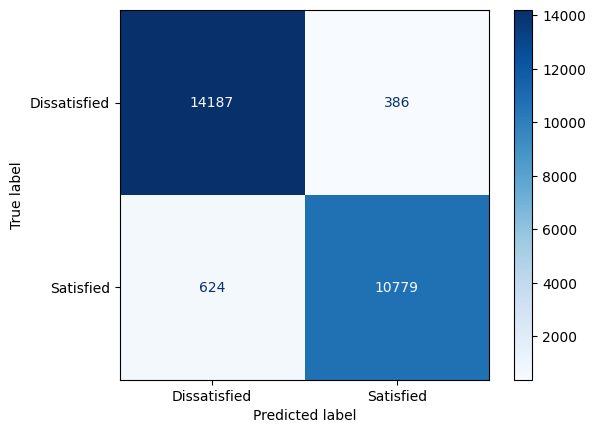

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = rf_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Dissatisfied","Satisfied"])
disp.plot(cmap="Blues")
plt.show()


In [ ]:
import shap
shap.initjs()

c:\Users\naqsh\.conda\envs\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\naqsh\.conda\envs\my_env\lib\site-packages\shap\explainers\_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


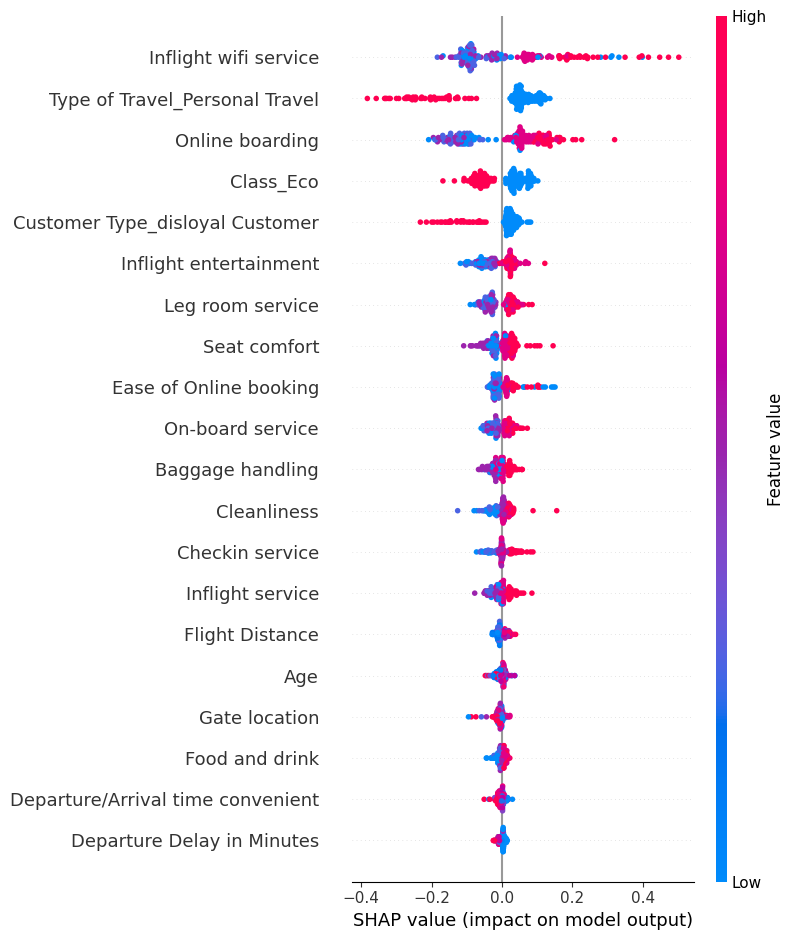

In [16]:
import shap
shap.initjs()

rf = rf_model.named_steps["clf"]
X_test_transformed = rf_model.named_steps["prep"].transform(X_test)

ohe = rf_model.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(cat_names)

sample_size = min(200, X_test_transformed.shape[0])
sample_idx = np.random.choice(X_test_transformed.shape[0], sample_size, replace=False)
X_sample = X_test_transformed[sample_idx]


explainer = shap.TreeExplainer(rf, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values[:, :, 1], X_sample, feature_names=feature_names)

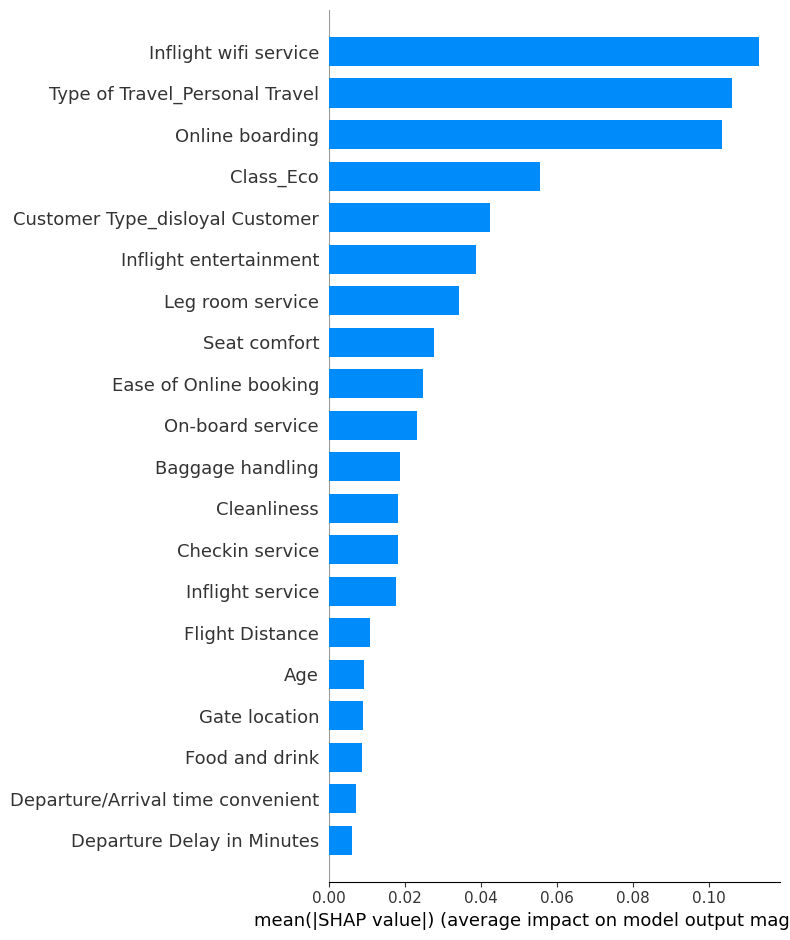

In [17]:
shap.summary_plot(shap_values[:, :, 1], X_sample, feature_names=feature_names, plot_type="bar")

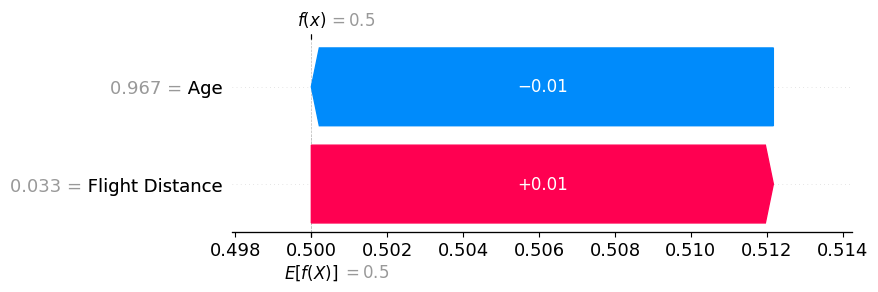

In [18]:
index = 10


ex = shap.Explanation(
    values = shap_values[1][index],
    base_values = explainer.expected_value[1],
    data = X_sample[index],
    feature_names = feature_names
)

shap.plots.waterfall(ex, max_display=12)


DASHBOARD :

In [19]:
fig = px.pie(df_train, names="satisfaction", title="Overall Satisfaction Distribution", hole=0.4)
fig.show()

In [20]:
for col in ["Customer Type", "Type of Travel", "Class", "Gender"]:
    fig = px.bar(
        df_train.groupby(col)["satisfaction"].mean().reset_index(),
        x=col, y="satisfaction", text_auto=True,
        title=f"Satisfaction Rate by {col}"
    )
    fig.show()


In [21]:
service_cols = [
    "Inflight wifi service", "Online boarding", "Seat comfort",
    "Inflight entertainment", "Food and drink", "Cleanliness",
    "Checkin service", "Baggage handling"
]

scores = df_train.groupby("satisfaction")[service_cols].mean().T
fig = px.bar(scores, barmode="group", title="Average Service Ratings (Satisfied vs Dissatisfied)")
fig.show()


In [23]:
import joblib

joblib.dump(rf_model, 'airline_model.pkl')

print("Model saved as airline_model.pkl")

Model saved as airline_model.pkl
